In [163]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd 

import jax 
import jax_cosmo as jc 
import jax.numpy as jnp
from jax_cosmo.scipy.integrate import simps

import pyccl as ccl


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
# Cosmology 
cosmo = jc.Cosmology(Omega_c=0.238, Omega_b=0.047, h=0.7, sigma8 = 0.8, n_s=0.96,
         Omega_k=0., w0=-1., wa=0.)

cosmo_ccl = ccl.Cosmology(Omega_c=0.238, Omega_b=0.047, h=0.7, n_s=0.96, sigma8=0.8,
        Neff=0, transfer_function="eisenstein_hu", matter_power_spectrum="halofit")

# Constants 
c = jc.constants.c
H0 = jc.constants.H0 * cosmo.h

In [221]:
# Ranges 
ellvec = np.linspace(1, 500, 500).astype(int)
kvec = np.logspace(-4, np.log10(4), 2000)
#zvec = np.linspace(0.0, 0.65, 1000)
zvec = np.arange(0., 0.65, 0.05)
avec = 1/(1+zvec)

# Smail parameters (smail) - Blazek+2019
n_smail = 5.42e+5
a_smail = 1.12e+00
b_smail = 3.41e+00
z0_smail = 4.070e-1

In [222]:
# Redshift distribution
nzvec = jc.redshift.smail_nz(a_smail, b_smail, z0_smail)

# Velocity Tracer 
tracer_vv = jc.probes.PeculiarVelocity([nzvec])

# Velocity Window Function
window_vv = tracer_vv.kernel(cosmo, zvec, ellvec)

### Limber 

In [223]:
cl_limber = jc.angular_cl.angular_cl(cosmo, ellvec, [tracer_vv])

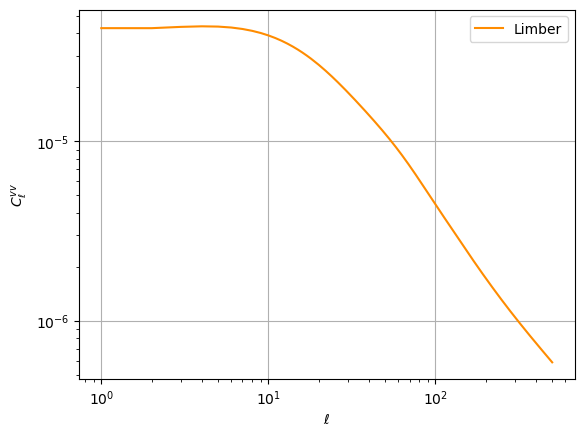

In [224]:
plt.plot(ellvec, cl_limber[0], color='darkorange', label='Limber')
plt.loglog()
plt.ylabel('$C_{\ell}^{vv}$')
plt.xlabel('$\ell$')
plt.grid()
plt.legend();


### Non-Limber 

In [166]:
def smail_distribution(z, n, a, b, z0, normed=False):
    '''Add information about what this function does and the parameters'''
    dndz = n * (z**a) * np.exp(-(z/z0)**b)
    
    if normed:
        dndz = dndz / sp.integrate.simps(dndz, z)
    
    return dndz

def velocity_window(cosmo, a, dndz, H0, normed): 
    # Redshift 
    zvec = 1/a -1 
    
    # Hubble Parameter 
    H_z = jc.background.H(cosmo, a)

    # Growth rate 
    f = jc.background.growth_rate(cosmo, a)

    kernel = a * H_z * f * dndz

    if normed:
        integral = sp.integrate.simps(kernel, zvec)
        kernel = kernel/integral 

    return kernel

def velocity_kernel_integrand(chi, ell, k, window):

    j_prime = sp.special.spherical_jn(ell, np.outer(k, chi), derivative=True)
    window = sp.interpolate.splev(chi, window, ext=0)

    return  window * j_prime

def cell_integrand(k, window1, window2):

    pk = ccl.nonlin_matter_power(cosmo_ccl, k*cosmo.h, 1.0)*cosmo.h**3
    #pk = jc.power.nonlinear_matter_power(cosmo, k, 1.0, transfer_fn=jc.transfer.Eisenstein_Hu, nonlinear_fn=jc.power.halofit)
    window1 = sp.interpolate.splev(k, window1, ext=0)
    window2 = sp.interpolate.splev(k, window2, ext=0)

    return window1 * window2 * pk 

def velocity_cl(chi, window_chi, ks, ells, output_file_path):

    cl_vv = np.zeros(len(ells))

    for i, ell in enumerate(ells):
        velocity_kernel = np.zeros(len(ks))
        for k, kval in enumerate(ks):
            velocity_kernel[k] = sp.integrate.quad(velocity_kernel_integrand, chi[0], chi[-1], args=(ell, kval, window_chi), limit=5000, epsrel=1e-6, epsabs=1e-12)[0]
        velocity_kernel_spline = sp.interpolate.splrep(ks, velocity_kernel)
        cl_vv[i] = (2/np.pi) * sp.integrate.quad(cell_integrand, ks[0], ks[-1], args=(velocity_kernel_spline, velocity_kernel_spline), limit=5000, epsrel=1e-6, epsabs=1e-12)[0]
        print(ell, cl_vv[i]) 
        #break
    
    np.savetxt(output_file_path, cl_vv, fmt="%g", header="Cl_uu")
    return cl_vv


In [167]:
file_path = '/Users/joaopedrobonifacio/Documents/lib/python/jax_cosmo/notebooks/cl_non_limber_blazek.csv'

chi = jc.background.radial_comoving_distance(cosmo, avec)
dndz = smail_distribution(zvec, n_smail, a_smail, b_smail, z0_smail, normed=False)
window_z = velocity_window(cosmo, avec, dndz, H0, normed=False)

window_chi = sp.interpolate.splrep(chi, window_z * jc.background.growth_factor(cosmo, avec) * jc.background.H(cosmo, avec) / c / (zvec[1] - zvec[0]) / np.sum(dndz))

/Users/joaopedrobonifacio/anaconda3/envs/firecrown_developer/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [ ]:
# Calculating the Cell_uu
cl_non_limber = velocity_cl(chi, window_chi, kvec, ellvec, file_path)

In [173]:
cl_non_limber = pd.read_csv('/Users/joaopedrobonifacio/Documents/lib/python/jax_cosmo/notebooks/cl_vv_non_limber_blazek.csv')
cl_non_limber = cl_non_limber['# Cl_uu'].values

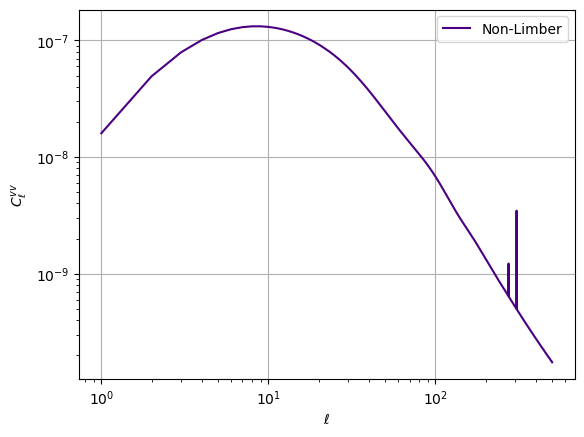

In [174]:
plt.plot(ellvec, cl_non_limber*(ellvec**3/c**2), color='indigo', label='Non-Limber')
plt.loglog()
plt.ylabel('$C_{\ell}^{vv}$')
plt.xlabel('$\ell$')
plt.grid()
plt.legend();

### Comprison between Limber and Non-Limber

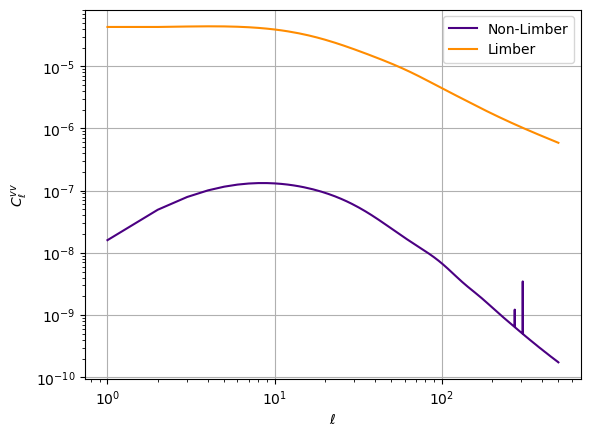

In [229]:
plt.plot(ellvec, cl_non_limber*(ellvec**3/c**2), color='indigo', label='Non-Limber')
plt.plot(ellvec, cl_limber[0], color='darkorange', label='Limber')
plt.loglog()
plt.ylabel('$C_{\ell}^{vv}$')
plt.xlabel('$\ell$')
plt.grid()
plt.legend();